In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern, RationalQuadratic, ConstantKernel as C

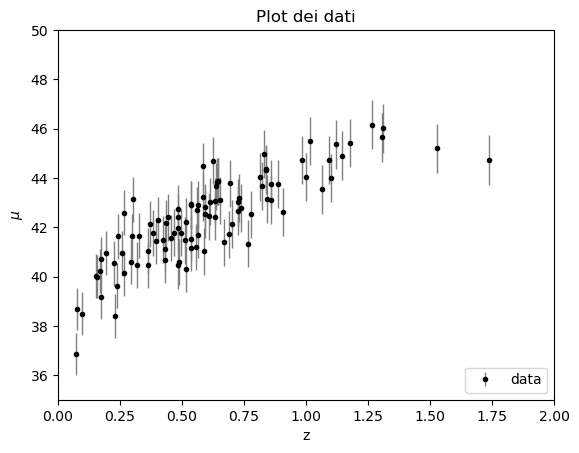

In [10]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title("Plot dei dati")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [45]:
#GPR ottimizza da solo i valori dei suoi parametri
z=np.linspace(0.01,2,1000)

length_scale = 1 
cost=1 

#in questo modo GPR non ottimizza il valore così vedo effettivamente cosa cambia
#kernel = C(cost, (cost, cost)) * RBF(length_scale, (length_scale, length_scale))  
#gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, optimizer=None) 

kernel = C(cost, (1e-2, 5e3)) * RBF(length_scale, (1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, n_restarts_optimizer=10)

gp.fit(z_sample[:, np.newaxis],mu_sample[:, np.newaxis])
mu_pred, sigma = gp.predict(z[:, np.newaxis], return_std=True)

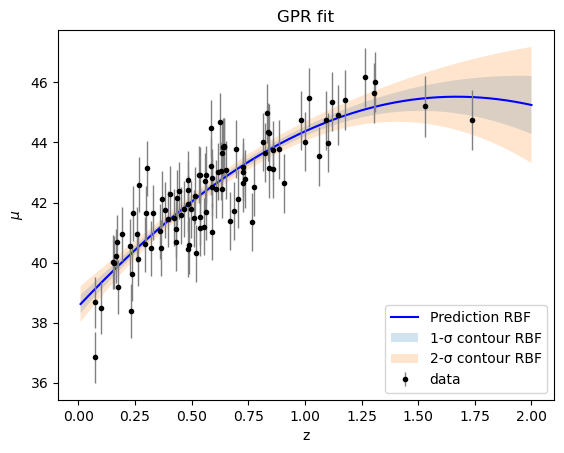

In [46]:
plt.plot(z, mu_pred, 'b-', label='Prediction RBF')
plt.fill_between(z.ravel(), mu_pred - sigma, mu_pred + sigma, alpha=0.2, label='1-σ contour RBF')
plt.fill_between(z.ravel(), mu_pred - 2*sigma, mu_pred + 2*sigma, alpha=0.2, label='2-σ contour RBF')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.legend()
plt.title("GPR fit")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show()


# NESTED SAMPLING per fare fit

In [21]:
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from astropy.cosmology import LambdaCDM

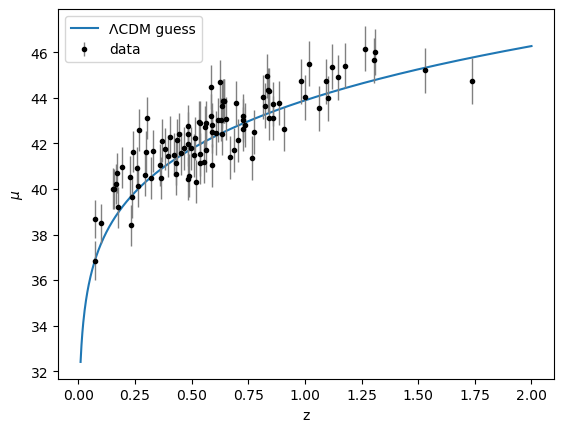

In [49]:
def model_mu(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value  

z=np.linspace(0.01,2, 1000)
H0=100
Om=0.0001
mu_prova=model_mu(z, H0, Om)

plt.plot(z, mu_prova, label="ΛCDM guess")
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.legend()
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show()


In [67]:
def loglike(params, z_sample, mu_sample, dmu):
    """Suppongo L gaussiana"""
    #posso non normalizzarla perchè è la stessa per entrambi i modelli
    H0, Om=params
    y1=model_mu(z_sample, H0, Om)
    
    #Calcolo logL perchè è più stabile di L
    logL=np.sum(-(mu_sample-y1)**2/(2*dmu**2))  
    
    return logL
 
def ptform(u):
    """H0 è uniforme in [10,100]
       Om è uniforme in [1e-2, 1]"""
    H0=10+(100-10)*u[0]
    Om=1e-2+(1-1e-2)*u[1]
    
    return np.array([H0, Om])

In [68]:
ndim=2
sampler = dynesty.NestedSampler(loglike, ptform, ndim, logl_args=[z_sample, mu_sample, dmu], nlive=1000, sample='rslice')
sampler.run_nested()

3023it [00:19, 152.16it/s, +1000 | bound: 0 | nc: 1 | ncall: 22444 | eff(%): 18.760 | loglstar:   -inf < -46.386 <    inf | logz: -49.134 +/-  0.029 | dlogz:  0.001 >  1.009]


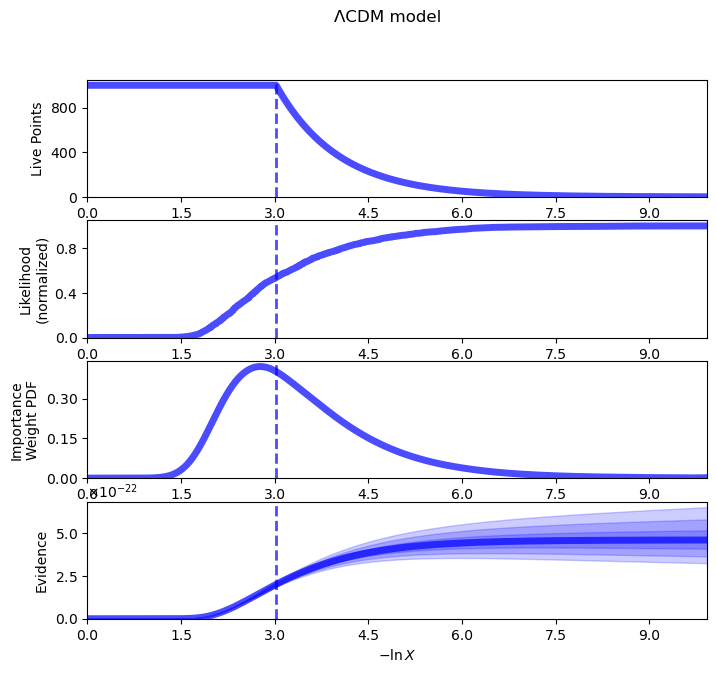

In [69]:
sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)
rfig.set_size_inches(8, 7) 
rfig.suptitle("ΛCDM model")
plt.show()

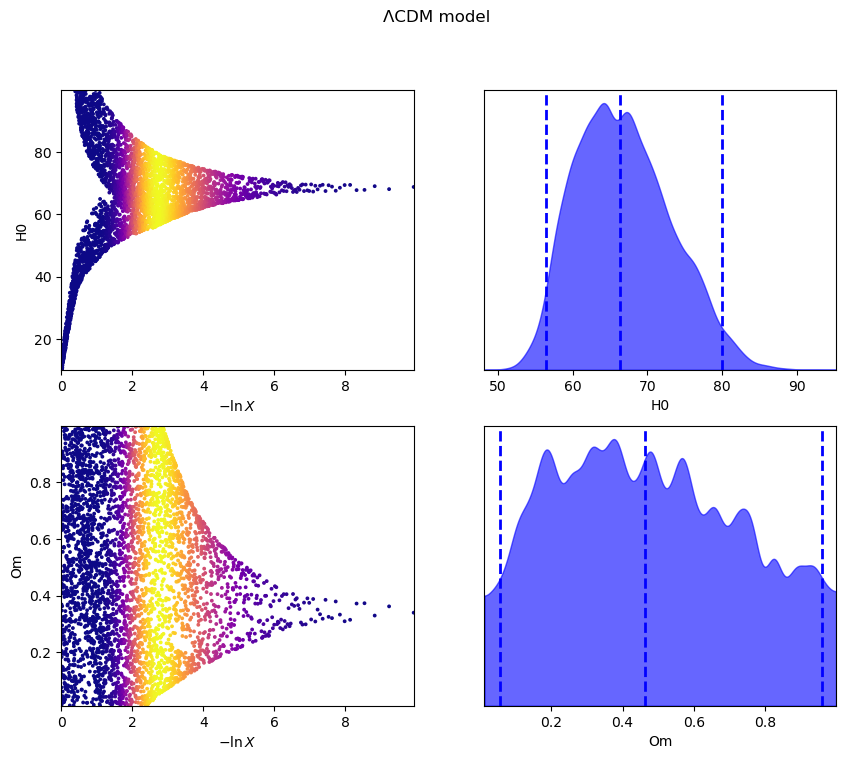

In [70]:
labels = ["H0","Om"]
tfig, taxes = dyplot.traceplot(sresults, labels=labels) 
tfig.suptitle("ΛCDM model")
tfig.set_size_inches(10, 8) 

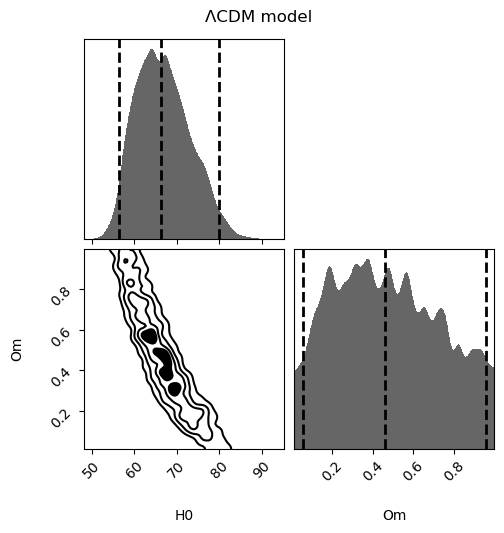

In [71]:
labels = ["H0", "Om"]
cfig, caxes = dyplot.cornerplot(sresults, labels=labels)
cfig.suptitle("ΛCDM model")
plt.show()

In [72]:
samples = sresults.samples  
weights = np.exp(sresults.logwt - sresults.logz[-1])  
#print(samples)

samples_equal = dyfunc.resample_equal(samples, weights)

evidence = sresults.logz[-1]          #log(evidence)
evidence_err = sresults.logzerr[-1]   #stima sull'errore associato a evidence

H0_ΛCDM=samples_equal[:, 0]
Om_ΛCDM=samples_equal[:, 1]

param=[H0_ΛCDM, Om_ΛCDM]
nomi=["H0", "Om"]

for par,lab in zip(param, nomi):
    best=np.median(par)
    lower_percentile = np.percentile(par, 5)  
    upper_percentile = np.percentile(par, 95)
    
    print("mediana di ", lab," : ", best, " - ", best-lower_percentile, " + ", upper_percentile-best, "al 90% di credibilità")

mediana di  H0  :  66.38797258314936  -  8.870216128582364  +  11.596978683800302 al 90% di credibilità
mediana di  Om  :  0.46098753310140245  -  0.37099440967917946  +  0.466555450775965 al 90% di credibilità


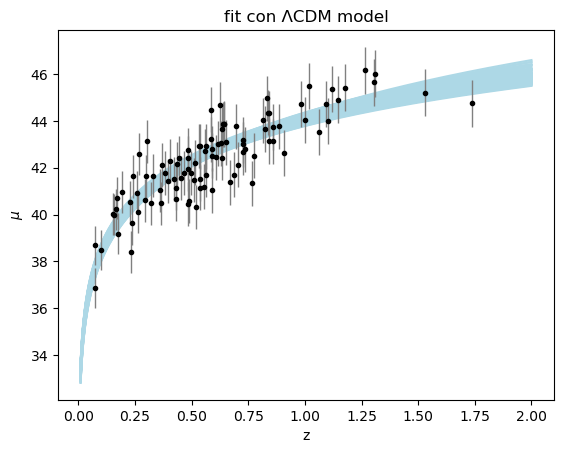

In [73]:
indici=np.random.choice(H0_ΛCDM.shape[0], size=100, replace=False)
H0100=H0_ΛCDM[indici]
Om100=Om_ΛCDM[indici]


for i in range(0,len(H0100)):
    y=model_mu(z, H0100[i], Om100[i])
    plt.plot(z, y, color='lightblue')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("fit con ΛCDM model")
plt.show()

In [57]:
#caso no dark energy 

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

def loglike(param, z_sample, mu_sample, dmu):
    """Suppongo L gaussiana"""
    #posso non normalizzarla perchè è la stessa per entrambi i modelli
    H0=param[0]
    Om=1
    y1=model_mu(z_sample, H0, Om)
    
    #FACCIO SUBITO IL LOGL,  così è più stabile
    logL=np.sum(-(mu_sample-y1)**2/(2*dmu**2))  
    
    return logL
 
def ptform(u):
    """H0 è uniforme in [10,100]"""
    H0=10+(100-10)*u[0]
    
    return [H0]

In [58]:
ndim=1
sampler = dynesty.NestedSampler(loglike, ptform, ndim, logl_args=[z_sample, mu_sample, dmu], nlive=1000, sample='rslice')
sampler.run_nested()

2981it [00:17, 174.55it/s, +1000 | bound: 0 | nc: 1 | ncall: 22170 | eff(%): 18.805 | loglstar:   -inf < -47.102 <    inf | logz: -49.706 +/-  0.012 | dlogz:  0.001 >  1.009]


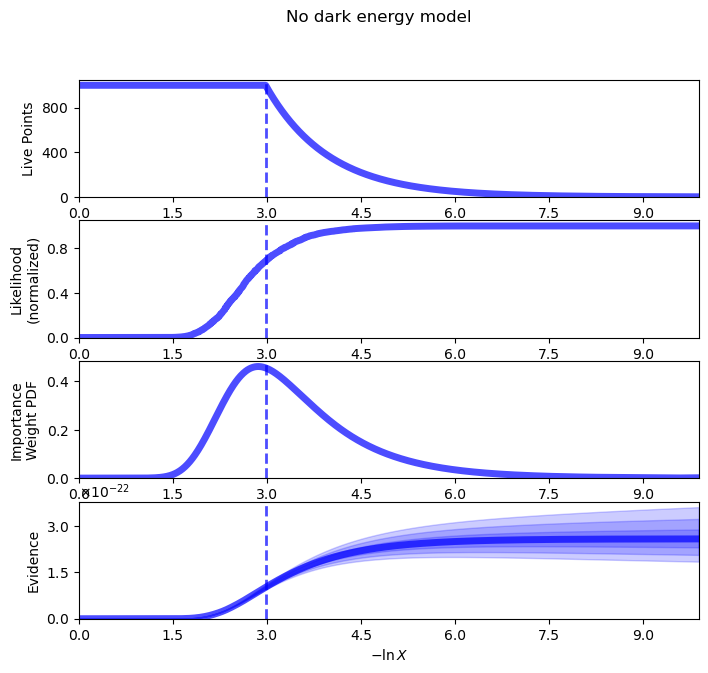

In [59]:
sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)
rfig.set_size_inches(8, 7) 
rfig.suptitle("No dark energy model")
plt.show()

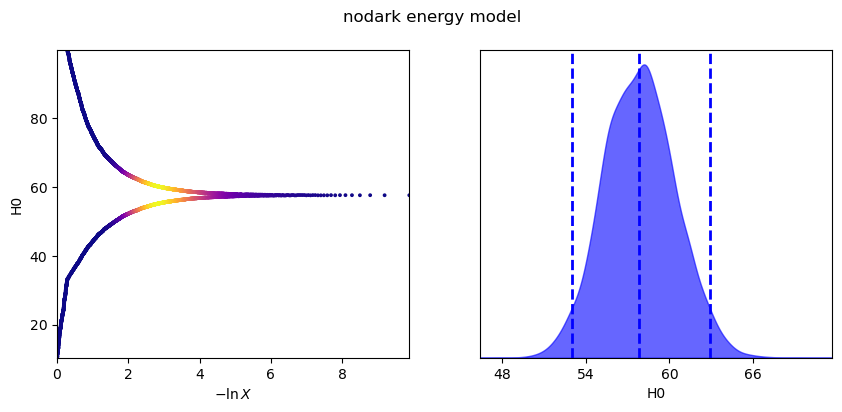

In [60]:
labels = ["H0"]
tfig, taxes = dyplot.traceplot(sresults, labels=labels) 
tfig.suptitle("nodark energy model")
tfig.set_size_inches(10, 4) 

In [62]:
samples1 = sresults.samples 
weights1 = np.exp(sresults.logwt - sresults.logz[-1])  
#print(samples)

samples_equal1 = dyfunc.resample_equal(samples1, weights1)

evidence1 = sresults.logz[-1]          #log(evidence)
evidence_err1 = sresults.logzerr[-1]   #stima sull'errore associato a evidence

H0=samples_equal1[:, 0]

best=np.median(H0)
lower_percentile = np.percentile(H0, 5)  
upper_percentile = np.percentile(H0, 95)

print("mediana di H0: ", best, " - ", best-lower_percentile, " + ", upper_percentile-best, "al 90% di credibilità")


mediana di H0:  57.852298056796464  -  4.026654038338265  +  4.311922601414459 al 90% di credibilità


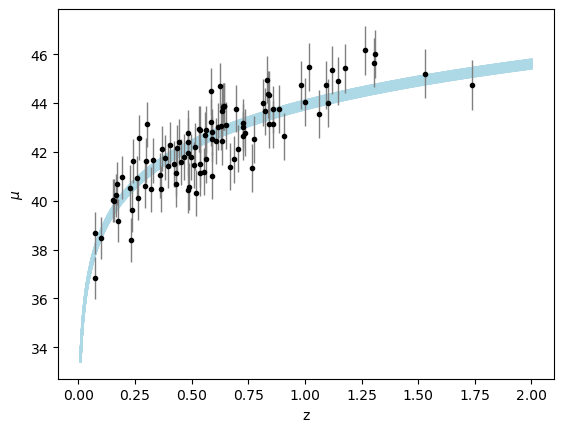

In [63]:
indici=np.random.choice(H0.shape[0], size=100, replace=False)
H0100=H0[indici]
Om=1

for i in range(0,len(H0100)):
    y=model_mu(z, H0100[i], Om)
    plt.plot(z, y, color='lightblue')#, alpha=1)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show()

In [64]:
bayes=np.exp(evidence)/np.exp(evidence1)                  #ΛCDM/no dark energy
bayes_err=bayes*np.sqrt(evidence_err**2+evidence_err1**2) 
print(bayes, "+/-", bayes_err)

#non posso dire nulla dall'Odds ratio

1.6903245013631059 +/- 0.27405108310291165


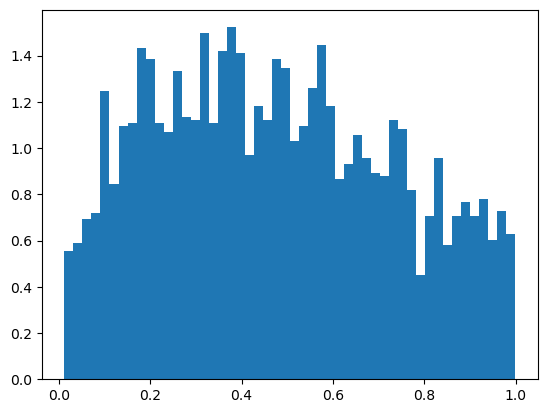

Savage-Dickey ratio: 1.6053608641667714


In [79]:
from sklearn.neighbors import KernelDensity

isto=plt.hist(Om_ΛCDM, bins=50, density=True)  #cambiando significativamente il numero di bins il valore a Om=1 non cambia molto
plt.show()

values=isto[0]
print("Savage-Dickey ratio:",1/(1-1e-2)/values[-1])

#risultato inconcludente, probabilmente dovrei avere più punti intorno a Om=1 per essere certa che il risultato sia affidabile

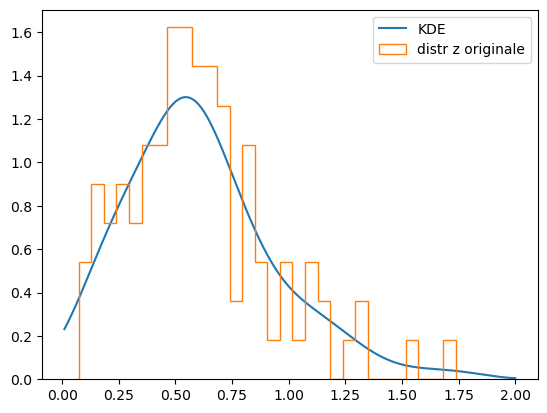

In [88]:
#per generare nuovi punti devo ottenere dei nuovi sample di z-> cerco la distribuzione di z

z=np.linspace(0.01,2,1000)
bwrange = np.linspace(0.01,1.0, 40) 
K = 5 
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) 
grid.fit(z_sample[:, np.newaxis]) 
h_opt = grid.best_params_['bandwidth']

kde_ottimale=KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(z_sample[:,np.newaxis])
pdf_ottimale = np.exp(kde_ottimale.score_samples((z)[:,np.newaxis]))

plt.plot(z, pdf_ottimale, label="KDE")
plt.hist(z_sample, bins=30, histtype='step', label="distr z originale", density=True)
plt.legend()
plt.show()

In [89]:
print(h_opt)

0.13692307692307693


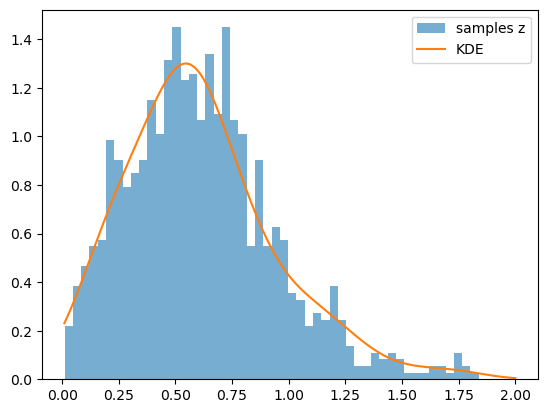

In [90]:
cdf = np.cumsum(pdf_ottimale)/np.sum(pdf_ottimale)

u=np.random.uniform(0,1,1000)

samples = np.interp(u, cdf, z)  

plt.hist(samples, bins=50, density=True, alpha=0.6, label="samples z")
plt.plot(z, pdf_ottimale, label="KDE")
plt.legend()
plt.show()

In [91]:
def model_mu(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

H0, Om = samples_equal[np.random.choice(samples_equal.shape[0])]
mu_lambda=model_mu(samples, H0, Om )

In [93]:
kernel = C(cost, (1e-2, 5e3)) * RBF(length_scale, (1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, n_restarts_optimizer=10)

z_vals=np.random.uniform(0.01,2,1000)
gp.fit(z_sample[:, np.newaxis],mu_sample[:, np.newaxis])
mu_cloned, sigma_cloned = gp.predict(z_vals[:, np.newaxis], return_std=True)

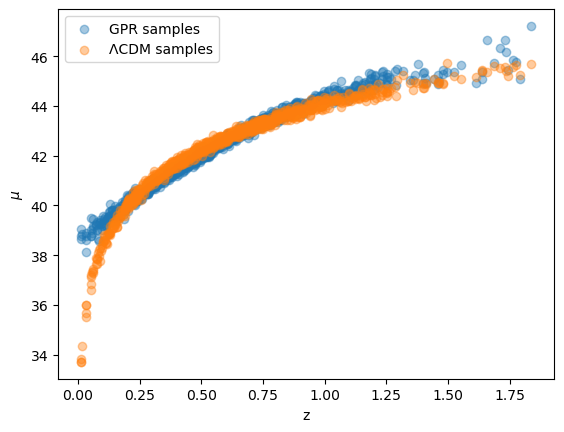

In [95]:
mu_gpr=[]
mu_lambda=[]

for z in samples:
    H0, Om = samples_equal[np.random.choice(samples_equal.shape[0])]
    mu_lambda=np.append(mu_lambda, model_mu(z,H0,Om))
    
    
    mu_pred, sigma = gp.predict([[z]], return_std=True)
    mu_gpr=np.append(mu_gpr,np.random.normal(loc=mu_pred,scale=sigma)) 

plt.scatter(samples, mu_gpr, alpha=0.4, label="GPR samples")
plt.scatter(samples, mu_lambda, alpha=0.4, label="ΛCDM samples")
plt.legend()
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show()

### FIT togliendo gli ultimi due punti

In [110]:
indici=np.argsort(z_sample)
z_new=z_sample[indici]
mu_new=mu_sample[indici]
dmu_new=dmu[indici]

z_new=z_new[:-2]
mu_new=mu_new[:-2]
dmu_new=dmu_new[:-2]

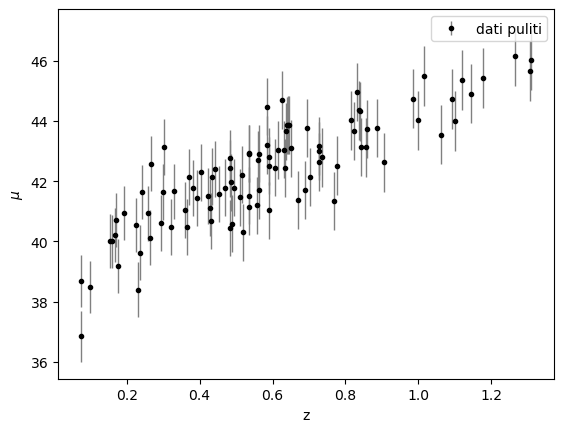

In [114]:
plt.errorbar(z_new, mu_new, dmu_new, fmt='.k', ecolor='gray', lw=1,label='dati puliti')
plt.legend()
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show()

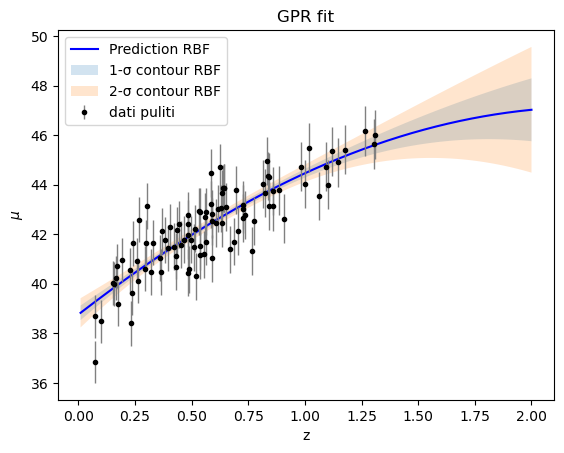

In [115]:
z=np.linspace(0.01,2,1000)

kernel = C(cost, (1e-2, 5e3)) * RBF(length_scale, (1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_new**2, n_restarts_optimizer=10)

gp.fit(z_new[:, np.newaxis],mu_new[:, np.newaxis])
mu_pred, sigma = gp.predict(z[:, np.newaxis], return_std=True)

plt.plot(z, mu_pred, 'b-', label='Prediction RBF')
plt.fill_between(z.ravel(), mu_pred - sigma, mu_pred + sigma, alpha=0.2, label='1-σ contour RBF')
plt.fill_between(z.ravel(), mu_pred - 2*sigma, mu_pred + 2*sigma, alpha=0.2, label='2-σ contour RBF')

plt.errorbar(z_new, mu_new, dmu_new, fmt='.k', ecolor='gray', lw=1,label='dati puliti')
plt.legend()
plt.title("GPR fit")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show()

In [ ]:
#NESTED SAMPLING

In [116]:
def loglike(params, z_new, mu_new, dmu_new):
    """Suppongo L gaussiana"""
    #posso non normalizzarla perchè è la stessa per entrambi i modelli
    H0, Om=params
    y1=model_mu(z_new, H0, Om)
    
    #Calcolo logL perchè è più stabile di L
    logL=np.sum(-(mu_new-y1)**2/(2*dmu_new**2))  
    
    return logL
 
def ptform(u):
    """H0 è uniforme in [10,100]
       Om è uniforme in [1e-2, 1]"""
    H0=10+(100-10)*u[0]
    Om=1e-2+(1-1e-2)*u[1]
    
    return np.array([H0, Om])

In [117]:
ndim=2
sampler = dynesty.NestedSampler(loglike, ptform, ndim, logl_args=[z_sample, mu_sample, dmu], nlive=1000, sample='rslice')
sampler.run_nested()

3099it [00:21, 146.47it/s, +1000 | bound: 0 | nc: 1 | ncall: 22886 | eff(%): 18.729 | loglstar:   -inf < -46.386 <    inf | logz: -49.200 +/-  0.028 | dlogz:  0.001 >  1.009]


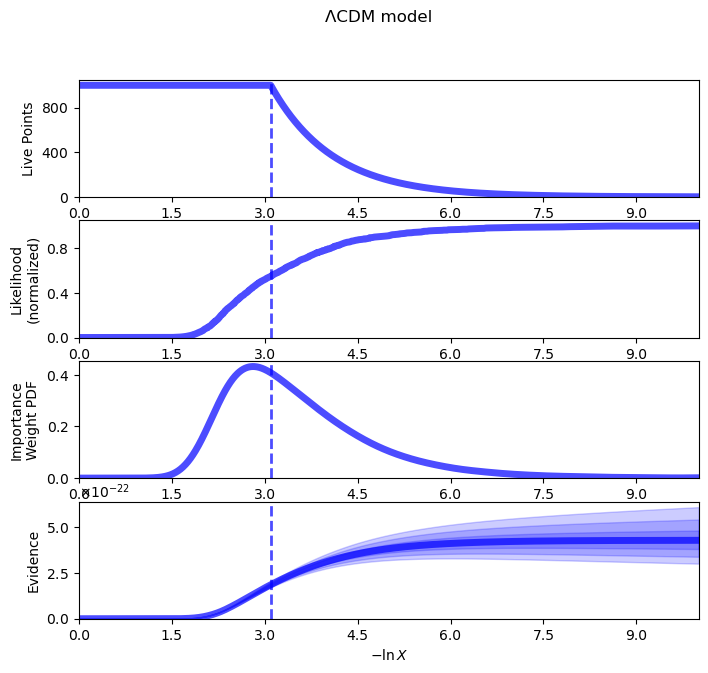

In [118]:
sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)
rfig.set_size_inches(8, 7) 
rfig.suptitle("ΛCDM model")
plt.show()

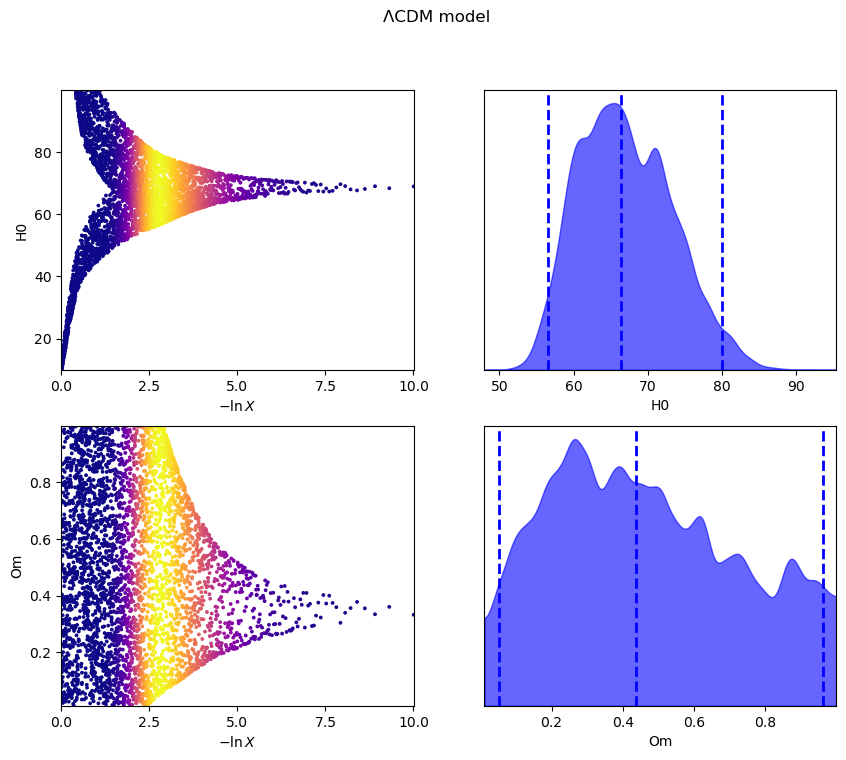

In [119]:
labels = ["H0","Om"]
tfig, taxes = dyplot.traceplot(sresults, labels=labels) 
tfig.suptitle("ΛCDM model")
tfig.set_size_inches(10, 8) 

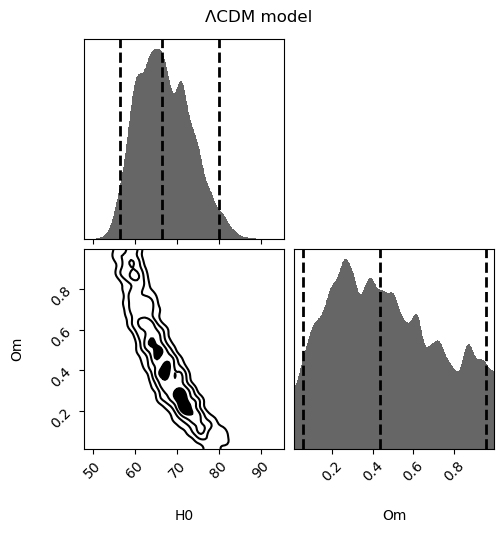

In [120]:
labels = ["H0", "Om"]
cfig, caxes = dyplot.cornerplot(sresults, labels=labels)
cfig.suptitle("ΛCDM model")
plt.show()

In [121]:
samples = sresults.samples  
weights = np.exp(sresults.logwt - sresults.logz[-1])  
#print(samples)

samples_equal = dyfunc.resample_equal(samples, weights)

evidence = sresults.logz[-1]          #log(evidence)
evidence_err = sresults.logzerr[-1]   #stima sull'errore associato a evidence

H0_pulito=samples_equal[:, 0]
Om_pulito=samples_equal[:, 1]

param=[H0_pulito, Om_pulito]
nomi=["H0", "Om"]

for par,lab in zip(param, nomi):
    best=np.median(par)
    lower_percentile = np.percentile(par, 5)  
    upper_percentile = np.percentile(par, 95)
    
    print("mediana di ", lab," : ", best, " - ", best-lower_percentile, " + ", upper_percentile-best, "al 90% di credibilità")

mediana di  H0  :  66.49154064704827  -  8.751587648477255  +  11.55687855651486 al 90% di credibilità
mediana di  Om  :  0.43626768228271406  -  0.35213969446533455  +  0.4917868479740206 al 90% di credibilità


valori con  tutti i dati:

mediana di  H0  :  66.38797258314936  -  8.870216128582364  +  11.596978683800302 al 90% di credibilità

mediana di  Om  :  0.46098753310140245  -  0.37099440967917946  +  0.466555450775965 al 90% di credibilità

In [ ]:
#i valori sono compatibili